<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

##Работа с датасетом

In [46]:
import copy
import transformers
from torch import nn
from typing import Union, Dict
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Optional, Any

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Преодобработаем данные

##Прочитаем файл и удалим пустые строчки

In [3]:
df_ru = pd.read_excel('/content/data_problems.xlsx')
df_eng = pd.read_excel('/content/data_problems_translated.xlsx')

df_ru = df_ru.drop('Unnamed: 0', axis=1)
df_eng = df_eng.drop('Unnamed: 0', axis=1)

df_ru.dropna(inplace=True)
df_eng.dropna(inplace=True)

label_encoder = LabelEncoder()
df_ru["Тема"] = label_encoder.fit_transform(df_ru["Тема"])
df_eng["topic"] = label_encoder.fit_transform(df_eng["topic"])

In [4]:
df_ru.head()

,Задача,Тема
0,Между девятью планетами Солнечной системы введ...,1
1,"В стране Цифра есть 9 городов с названиями 1, ...",1
2,"В государстве 100 городов, и из каждого из них...",1
3,"В классе 30 человек. Может ли быть так, что 9 ...",1
4,В городе Маленьком 15 телефонов. Можно ли их с...,1


In [5]:
df_eng.head()

,problem_text,topic
0,To prove that the sum of the numbers of the ex...,5
1,( b) Will the statement of the previous challe...,5
2,The quadratic three-member graph with the coef...,6
3,Can you draw on the surface of Rubik's cube a ...,0
4,"Dima, who came from Vrunlandia, said that ther...",3


#Разделим данные и иницианилизируем токенизаторы

In [6]:
train_ru_data, test_ru_data = train_test_split(df_ru, test_size=0.2)
train_eng_data, test_eng_data = train_test_split(df_eng, test_size=0.2)

In [ ]:
ru_tokenizer = transformers.AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
eng_tokenizer = transformers.AutoTokenizer.from_pretrained("tbs17/MathBert")

#Токенизируем данные и создаем даталоадеры

In [8]:
train_ru_task = ru_tokenizer(train_ru_data["Задача"].to_list(), padding=True,
                             truncation=True, max_length=512, return_tensors="pt")

test_ru_task = ru_tokenizer(test_ru_data["Задача"].to_list(), padding=True,
                            truncation=True, max_length=512, return_tensors="pt")

train_eng_task = eng_tokenizer(train_eng_data["problem_text"].to_list(), padding=True,
                               truncation=True, max_length=512, return_tensors="pt")

test_eng_task = eng_tokenizer(test_eng_data["problem_text"].to_list(), padding=True,
                              truncation=True, max_length=512, return_tensors="pt")

In [9]:
train_ru_dataset = TensorDataset(train_ru_task["input_ids"],
                                 train_ru_task["attention_mask"],
                                 train_ru_task["token_type_ids"],
                                 torch.tensor(train_ru_data["Тема"].values)
                                 )

test_ru_dataset = TensorDataset(test_ru_task["input_ids"],
                                test_ru_task["attention_mask"],
                                test_ru_task["token_type_ids"],
                                torch.tensor(test_ru_data["Тема"].values)
                                )

train_eng_dataset = TensorDataset(train_eng_task["input_ids"],
                                  train_eng_task["attention_mask"],
                                  train_eng_task["token_type_ids"],
                                  torch.tensor(train_eng_data["topic"].values)
                                  )

test_eng_dataset = TensorDataset(test_eng_task["input_ids"],
                                 test_eng_task["attention_mask"],
                                 test_eng_task["token_type_ids"],
                                 torch.tensor(test_eng_data["topic"].values)
                                 )

In [10]:
train_ru_dataloader = DataLoader(train_ru_dataset, batch_size=32, shuffle=True)
test_ru_dataloader = DataLoader(test_ru_dataset, batch_size=32, shuffle=False)

train_eng_dataloader = DataLoader(train_eng_dataset, batch_size=32, shuffle=True)
test_eng_dataloader = DataLoader(test_eng_dataset, batch_size=32, shuffle=False)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [22]:
class TransformerClassificationModel(nn.Module):
    def __init__(
          self,
          base_transformer_model: Union[str, nn.Module],
          num_classes: int
        ):
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model)
        config = transformers.AutoConfig.from_pretrained(base_transformer_model)

        self.hidden_size = config.hidden_size

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.classifier = nn.Linear(self.hidden_size, num_classes)

    def forward(
          self,
          input_ids,
          attention_mask=None,
          token_type_ids=None
        ) -> Dict[str, torch.Tensor]:

        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        pooled_output = outputs.last_hidden_state[:, 0, :]

        pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        return {'logits': logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [12]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for name, param in model.named_parameters():
        if "backbone" in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [20]:
def train_transformer(transformer_model, train_loader, test_loader,
                      freeze_backbone=True, epochs=5):
    model = copy.copy(transformer_model)
    model.to(device)

    if freeze_backbone:
        freeze_backbone_function(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    losses = []
    accuracy = []
    for epoch in range(epochs):
        model.train()
        losses_per_epoch = []
        cur_loss = 0
        for batch in tqdm(train_loader, desc=f"Training {epoch+1} epoch"):
            optimizer.zero_grad()
            input_ids, attention_mask, token_type_ids, label = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            label = label.to(device)
            outputs = model(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
            loss = criterion(outputs["logits"], label)
            loss.backward()
            optimizer.step()
            losses_per_epoch.append(loss.item())
            cur_loss += loss.item()

        losses.append(np.mean(losses_per_epoch))

        model.eval()
        test_acc = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, token_type_ids, label = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                label = label.to(device)
                outputs = model(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids)
                preds = torch.argmax(outputs["logits"], dim=1)
                test_acc += (preds == label).sum().item() / len(label)

        test_acc /= len(test_loader)
        accuracy.append(test_acc)
        print(f"Train Loss: {losses[-1]} Test accuracy: {accuracy[-1]}")

    return model, losses, accuracy

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [23]:
print('Модель с заморозкой')
print()
print()
rubert_tiny_transformer_model_freeze = TransformerClassificationModel('cointegrated/rubert-tiny2',
                                                                      num_classes=7)
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(transformer_model=rubert_tiny_transformer_model_freeze,
                                                                freeze_backbone=True,
                                                                train_loader=train_ru_dataloader,
                                                                test_loader=test_ru_dataloader,
                                                                epochs=10)
print()
print()
print('Модель без заморозки')
print()
print()
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2', num_classes=7)
rubert_tiny_full_finetuned = train_transformer(transformer_model=rubert_tiny_transformer_model,
                                               freeze_backbone=False,
                                               train_loader=train_ru_dataloader,
                                               test_loader=test_ru_dataloader,
                                               epochs=10)

Модель с заморозкой




Training 1 epoch: 100%|██████████| 132/132 [00:08<00:00, 15.88it/s]


Train Loss: 1.36882076615637 Test accuracy: 0.5545882209188661


Training 2 epoch: 100%|██████████| 132/132 [00:07<00:00, 18.06it/s]


Train Loss: 1.130939949190978 Test accuracy: 0.573619257086999


Training 3 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.76it/s]


Train Loss: 1.0734908160838215 Test accuracy: 0.5802785923753665


Training 4 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.53it/s]


Train Loss: 1.0299880080150836 Test accuracy: 0.5954301075268817


Training 5 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.29it/s]


Train Loss: 1.012971557451017 Test accuracy: 0.6020894428152492


Training 6 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.10it/s]


Train Loss: 0.9992381018219572 Test accuracy: 0.5992179863147605


Training 7 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.13it/s]


Train Loss: 0.9936103256362857 Test accuracy: 0.5973240469208211


Training 8 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.35it/s]


Train Loss: 0.9801513308828528 Test accuracy: 0.6087182306940371


Training 9 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.52it/s]


Train Loss: 0.9653387543830004 Test accuracy: 0.6106427174975563


Training 10 epoch: 100%|██████████| 132/132 [00:07<00:00, 17.66it/s]


Train Loss: 0.9655167862321391 Test accuracy: 0.6067326490713588


Модель без заморозки




Training 1 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.01it/s]


Train Loss: 1.1435667876944398 Test accuracy: 0.5440799120234604


Training 2 epoch: 100%|██████████| 132/132 [00:26<00:00,  4.97it/s]


Train Loss: 0.8847111346143665 Test accuracy: 0.5916116813294233


Training 3 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s]


Train Loss: 0.733762071213939 Test accuracy: 0.63327834799609


Training 4 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.02it/s]


Train Loss: 0.6645019016031063 Test accuracy: 0.5584371945259042


Training 5 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s]


Train Loss: 0.6226436628988294 Test accuracy: 0.593475073313783


Training 6 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s]


Train Loss: 0.5554964230819182 Test accuracy: 0.6114980449657869


Training 7 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.00it/s]


Train Loss: 0.5152084882738013 Test accuracy: 0.5603616813294233


Training 8 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.02it/s]


Train Loss: 0.49195821673581097 Test accuracy: 0.542369257086999


Training 9 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.02it/s]


Train Loss: 0.48496071192802803 Test accuracy: 0.5840359237536656


Training 10 epoch: 100%|██████████| 132/132 [00:26<00:00,  5.01it/s]


Train Loss: 0.4551488875665448 Test accuracy: 0.5661045943304007


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [33]:
print('Модель с заморозкой')
print()
print()
bert_tiny_transformer_model_freeze = TransformerClassificationModel('tbs17/MathBert', num_classes=7)
bert_tiny_finetuned_with_freezed_backbone = train_transformer(transformer_model=bert_tiny_transformer_model_freeze,
                                                                freeze_backbone=True,
                                                                train_loader=train_eng_dataloader,
                                                                test_loader=test_eng_dataloader,
                                                                epochs=5)
print()
print()
print('Модель без заморозки')
print()
print()
bert_tiny_transformer_model = TransformerClassificationModel('tbs17/MathBert', num_classes=7)
bert_tiny_full_finetuned = train_transformer(transformer_model=bert_tiny_transformer_model,
                                               freeze_backbone=False,
                                               train_loader=train_eng_dataloader,
                                               test_loader=test_eng_dataloader,
                                               epochs=5)

Модель с заморозкой




Training 1 epoch: 100%|██████████| 132/132 [01:57<00:00,  1.12it/s]


Train Loss: 1.392608227151813 Test accuracy: 0.5597222222222222


Training 2 epoch: 100%|██████████| 132/132 [01:58<00:00,  1.12it/s]


Train Loss: 1.1697551608085632 Test accuracy: 0.564520202020202


Training 3 epoch: 100%|██████████| 132/132 [01:58<00:00,  1.12it/s]


Train Loss: 1.1132700009779497 Test accuracy: 0.5740530303030303


Training 4 epoch: 100%|██████████| 132/132 [01:58<00:00,  1.12it/s]


Train Loss: 1.0996324433521791 Test accuracy: 0.57885101010101


Training 5 epoch: 100%|██████████| 132/132 [01:58<00:00,  1.12it/s]


Train Loss: 1.0736414966258137 Test accuracy: 0.5561237373737373


Модель без заморозки




Training 1 epoch: 100%|██████████| 132/132 [06:02<00:00,  2.74s/it]


Train Loss: 1.891952875888709 Test accuracy: 0.47632575757575757


Training 2 epoch: 100%|██████████| 132/132 [06:02<00:00,  2.74s/it]


Train Loss: 1.6944576303164165 Test accuracy: 0.47632575757575757


Training 3 epoch: 100%|██████████| 132/132 [06:02<00:00,  2.74s/it]


Train Loss: 1.6681987570993828 Test accuracy: 0.47632575757575757


Training 4 epoch: 100%|██████████| 132/132 [06:02<00:00,  2.74s/it]


Train Loss: 1.650947987130194 Test accuracy: 0.47632575757575757


Training 5 epoch: 100%|██████████| 132/132 [06:02<00:00,  2.74s/it]


Train Loss: 1.6517969956903746 Test accuracy: 0.47632575757575757


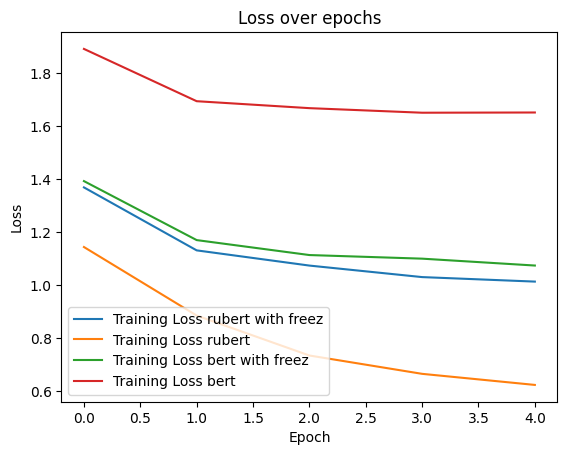

In [40]:
plt.plot(rubert_tiny_finetuned_with_freezed_backbone[1][0:5], label='Training Loss rubert with freez')
plt.plot(rubert_tiny_full_finetuned[1][0:5], label='Training Loss rubert')
plt.plot(bert_tiny_finetuned_with_freezed_backbone[1], label='Training Loss bert with freez')
plt.plot(bert_tiny_full_finetuned[1], label='Training Loss bert')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

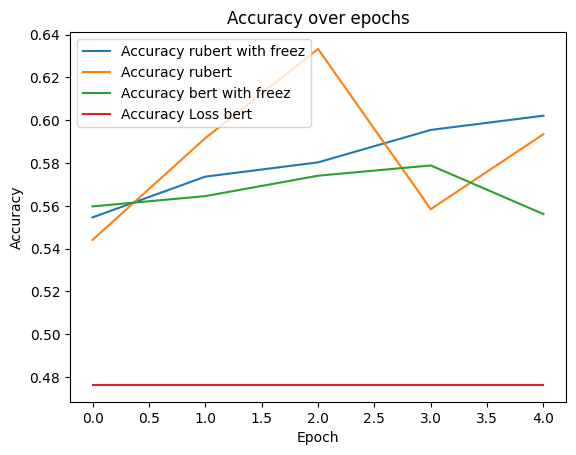

In [44]:
plt.plot(rubert_tiny_finetuned_with_freezed_backbone[2][0:5], label='Accuracy rubert with freez')
plt.plot(rubert_tiny_full_finetuned[2][0:5], label='Accuracy rubert')
plt.plot(bert_tiny_finetuned_with_freezed_backbone[2], label='Accuracy bert with freez')
plt.plot(bert_tiny_full_finetuned[2], label='Accuracy bert')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

##Сравнение моделей cointegrated/rubert-tiny2 и tbs17/MathBert
cointegrated/rubert-tiny2 показала стабильное улучшение accuracy с каждой эпохой, особенно без заморозки (достигла 0.633 на 3-й эпохе). Однако после 4-й эпохи accuracy снизилась, что может указывать на переобучение.

tbs17/MathBert с заморозкой показала скромные результаты (максимум 0.578), а без заморозки — катастрофически плохие (accuracy ~0.476, что близко к случайному угадыванию). Это говорит о том, что модель либо не подходит для задачи, либо требует особого подхода к обучению.


Лучшая модель: rubert-tiny2 без заморозки (accuracy 0.633) превзошла MathBert (максимум 0.578).

Заморозка: С заморозкой она обучалась стабильно, но accuracy низкая.

Скорость обучения: MathBert обучалась в 3-5 раз медленнее, что усугубляло проблемы.

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [60]:
def draw_first_layer_attention_maps(attention_head_ids, text: str, model: TransformerClassificationModel, ru=False):
    if ru:
        tokenized_text = ru_tokenizer(text,padding=True, truncation=True,
                                      max_length=512, return_tensors="pt")
    else:
        tokenized_text = eng_tokenizer(text,padding=True, truncation=True,
                                       max_length=512, return_tensors="pt")
    input_ids = tokenized_text["input_ids"].to(device)
    attention_mask = tokenized_text["attention_mask"]
    model.eval()
    with torch.no_grad():
        outputs = model.backbone(input_ids, output_attentions=True)
        first_layer_attentions = outputs[0]

    attentions = outputs.attentions

    fig, axes = plt.subplots(1, len(attention_head_ids), figsize=(12, 10))

    for idx, head_id in enumerate(attention_head_ids):
        attention = attentions[0][0, head_id].cpu().numpy()
        ax = axes[idx]
        im = ax.imshow(attention)
        ax.set_title(f'Head {head_id}')
        ax.set_xlabel('Tokens')
        ax.set_ylabel('Tokens')
        ax.set_xticks(range(len(input_ids[0])))
        ax.set_yticks(range(len(input_ids[0])))
        if ru:
            ax.set_xticklabels(ru_tokenizer.convert_ids_to_tokens(input_ids[0]), rotation=90)
            ax.set_yticklabels(ru_tokenizer.convert_ids_to_tokens(input_ids[0]))
        else:
            ax.set_xticklabels(eng_tokenizer.convert_ids_to_tokens(input_ids[0]), rotation=90)
            ax.set_yticklabels(eng_tokenizer.convert_ids_to_tokens(input_ids[0]))

    plt.tight_layout()
    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [65]:
ru_text = train_ru_data.sample(3)['Задача'].to_list()
eng_text = train_eng_data.sample(3)['problem_text'].to_list()

In [66]:
eng_text

["There is a n×n table whose columns are numbered in numbers 1 to n. In the cells of the table the numbers 1,..., n so that in each row and in each column all numbers are different. Let's call the cell good if the number in it is greater than the number of the column in which it is. What is the n position where all the rows have the same number of good cells?",
 'A graph of the function y = kx + b (see figure) is given on the coordinate plane. In the same coordinate plane plot a graph of the function y = kx2 + bx.',
 'On the board, they wrote 100 pairs of different natural numbers a1, a2,..., a100.']

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


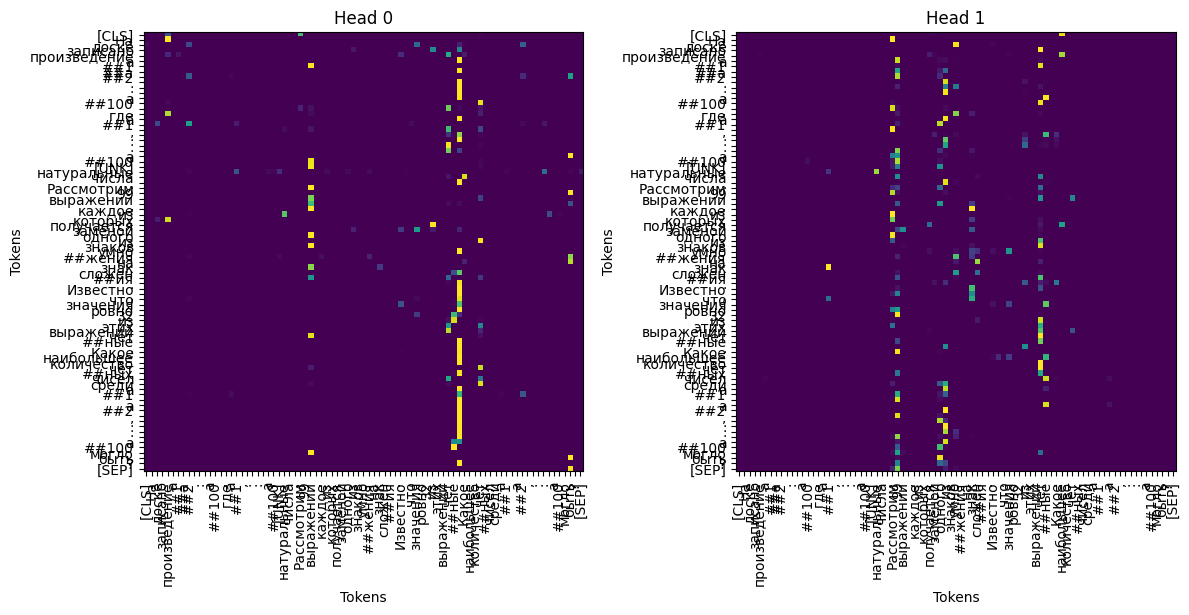

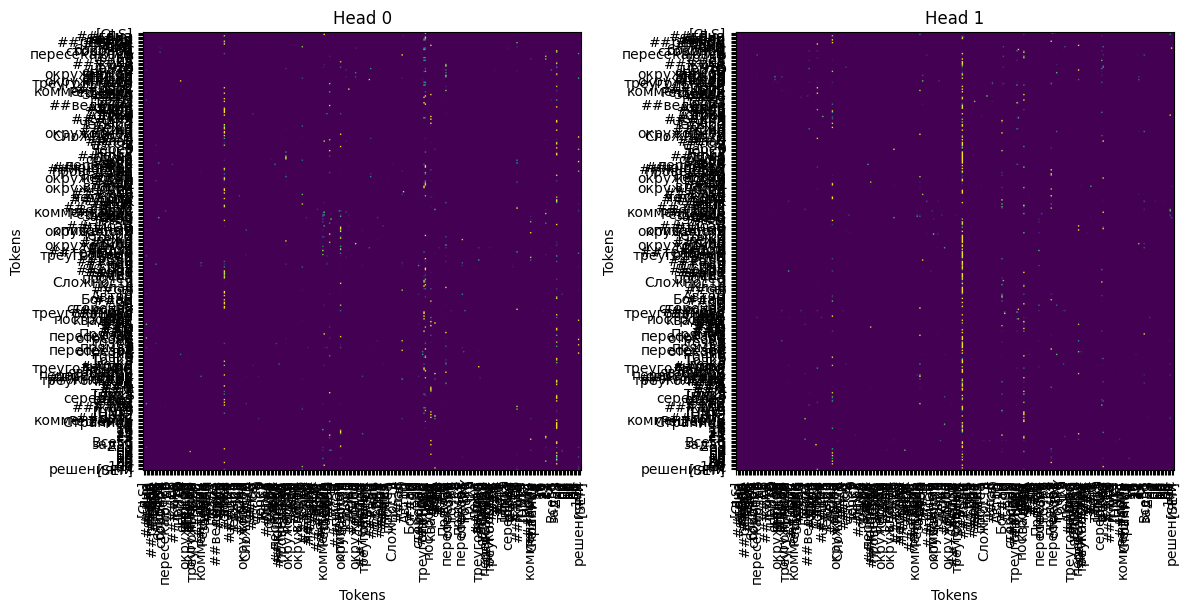

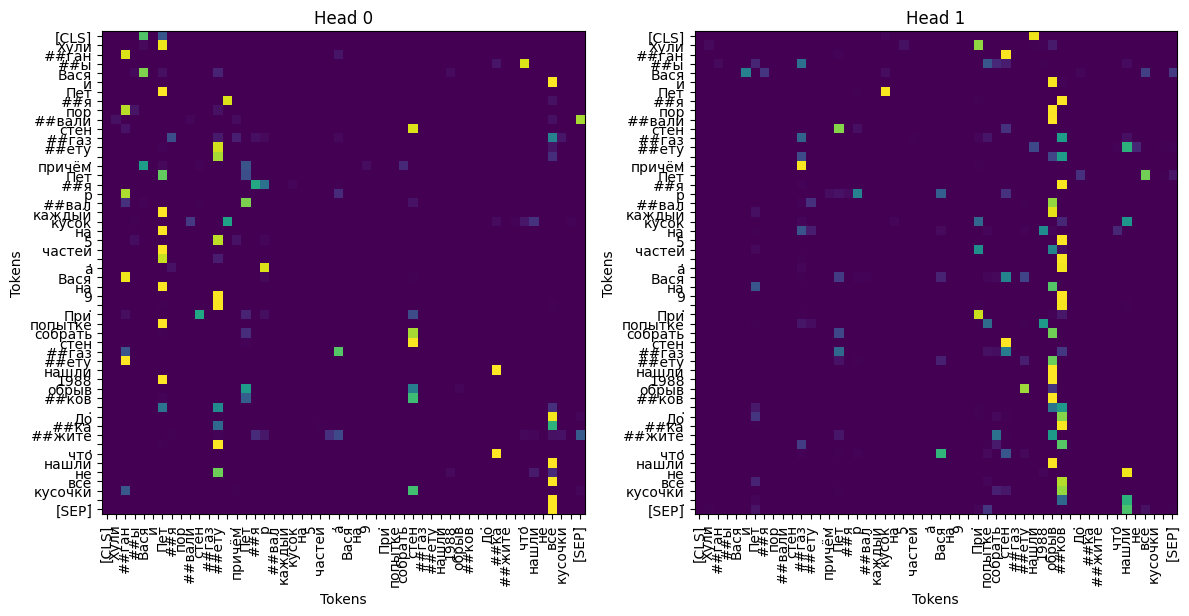

In [61]:
for sample in ru_text:
  draw_first_layer_attention_maps([0, 1], sample, rubert_tiny_transformer_model, ru=True)

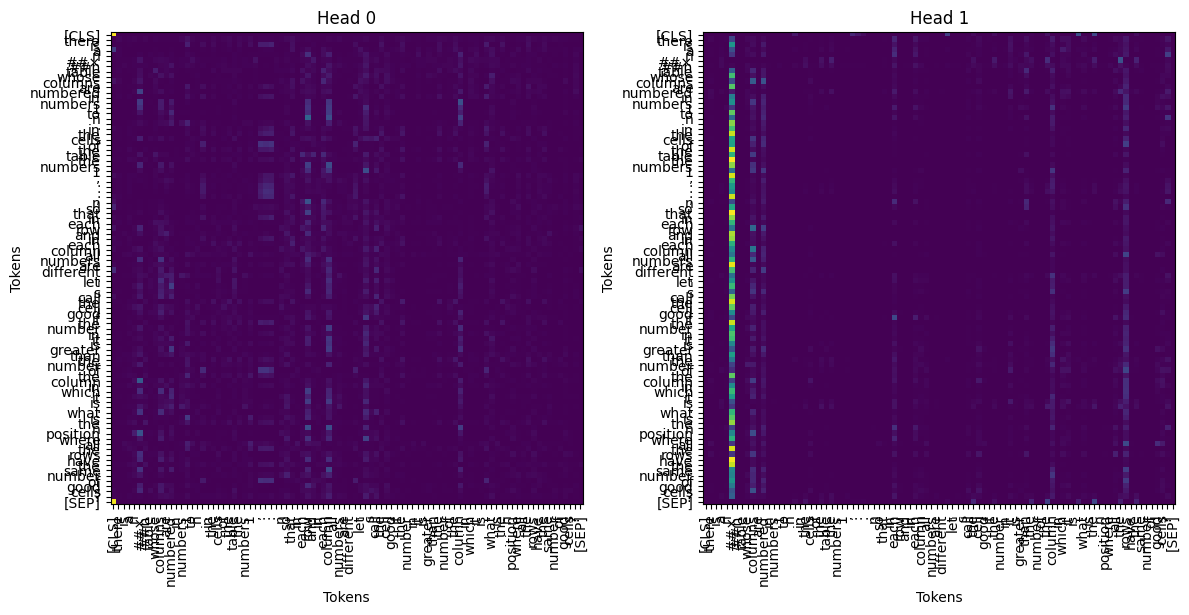

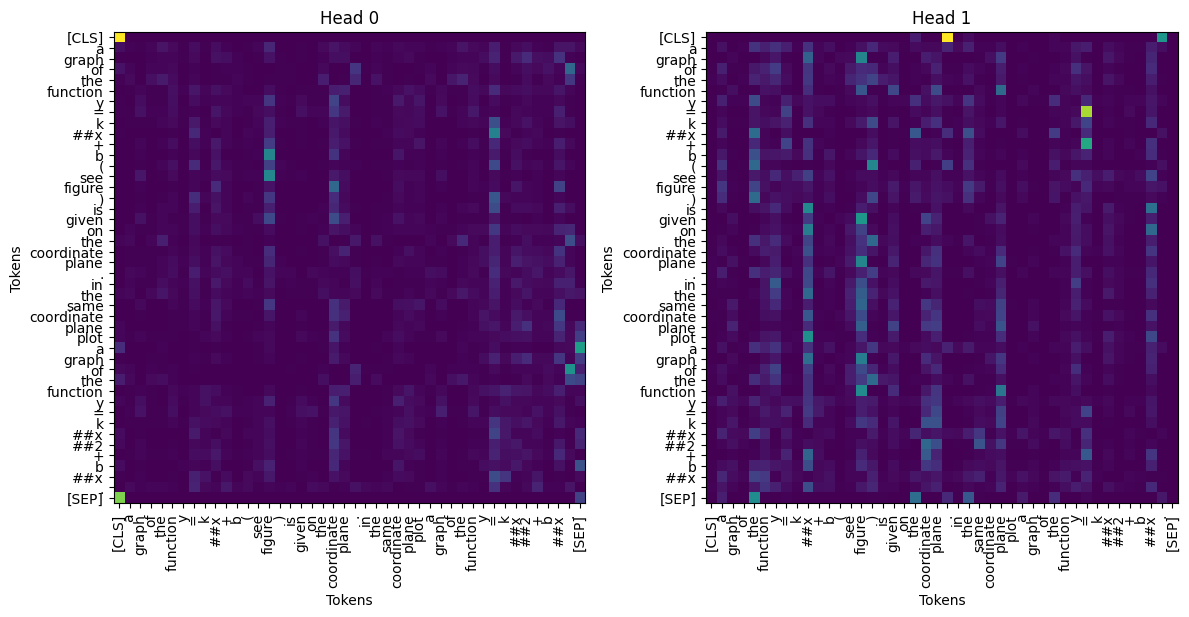

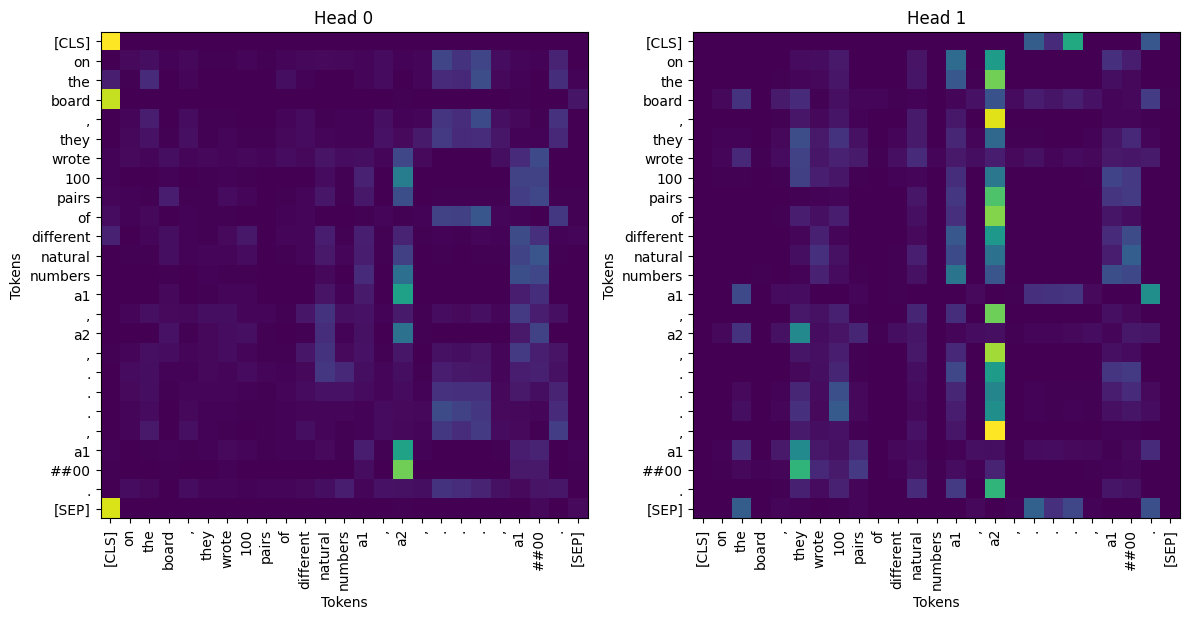

In [67]:
for sample in eng_text:
    draw_first_layer_attention_maps([0,1], sample, bert_tiny_transformer_model, ru=False)

В данном случае, как мы видим, rubert начал улавливать связи между словами, но в случае с mathbert мы видим, что модель практически совсем не видит эти связи

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

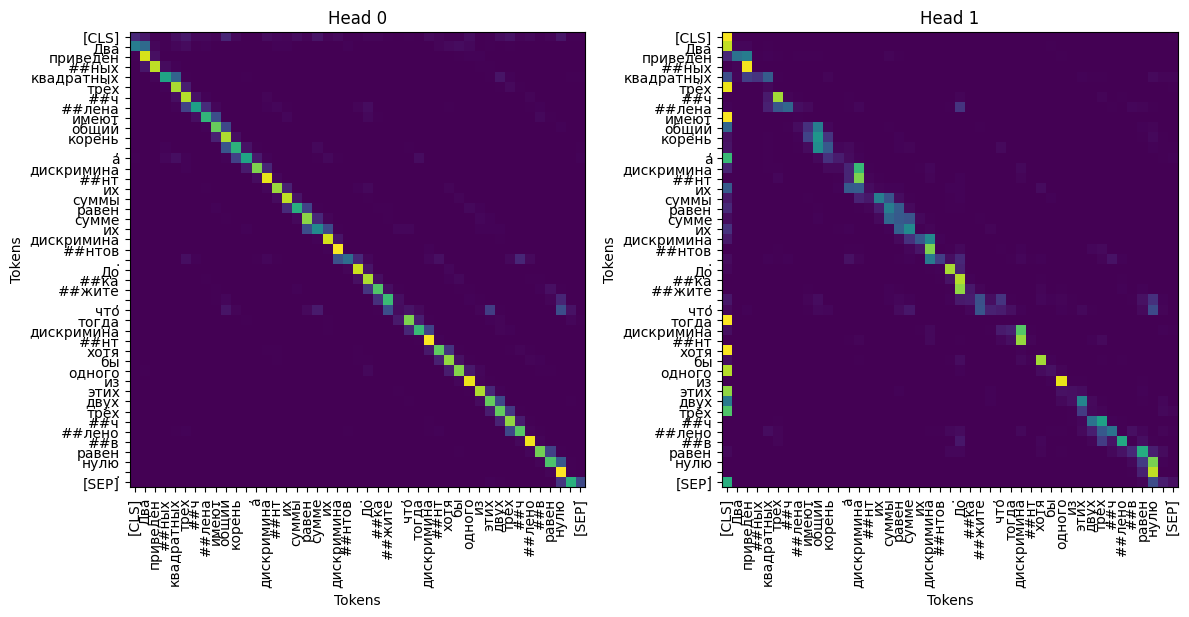

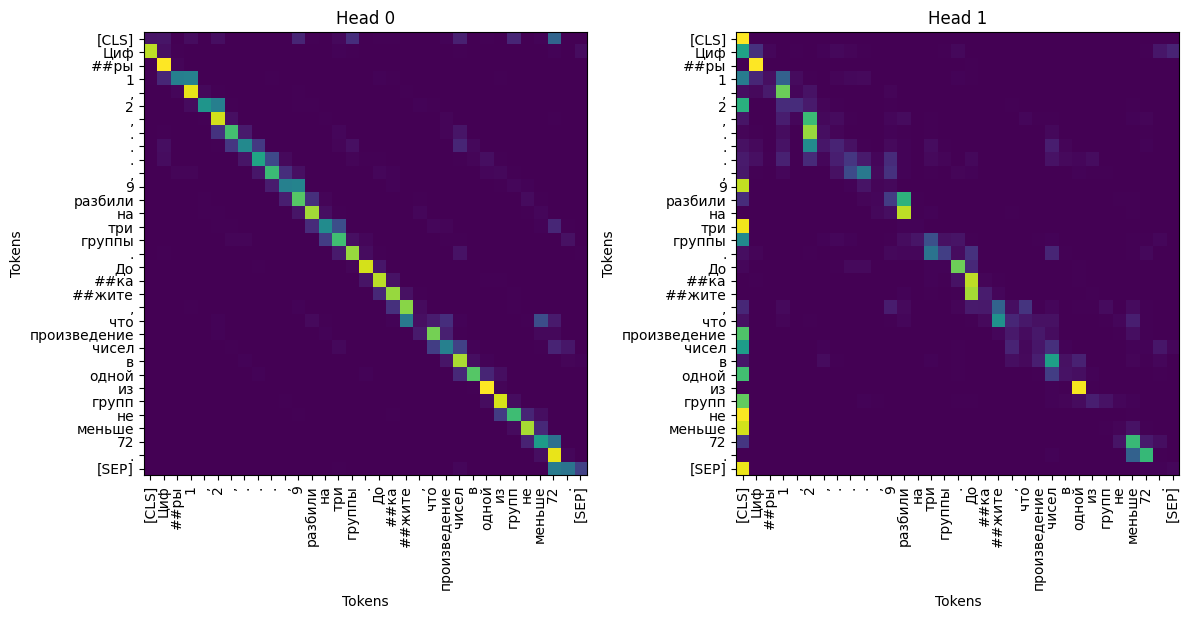

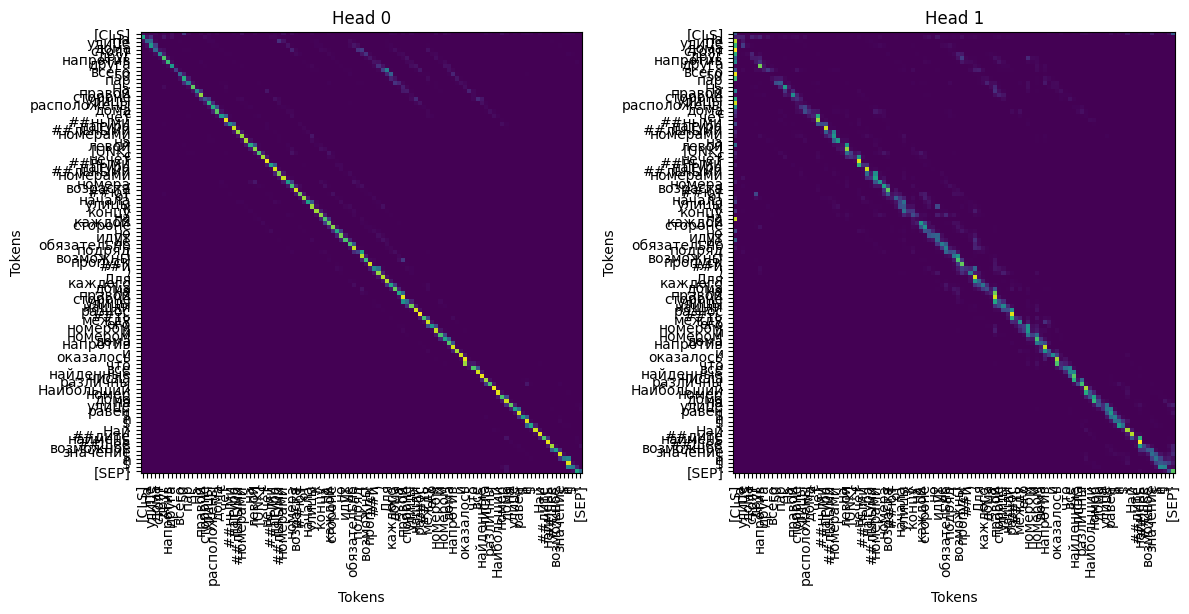

In [69]:
for sample in ru_text:
    draw_first_layer_attention_maps([0,1], sample, rubert_tiny_transformer_model_freeze, ru=True)

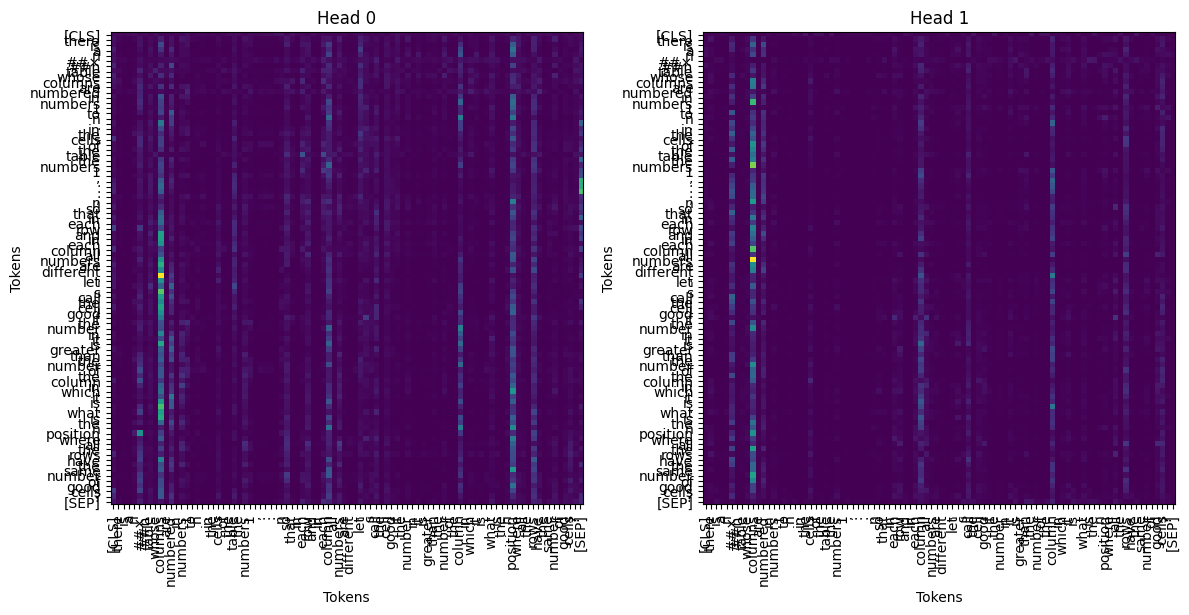

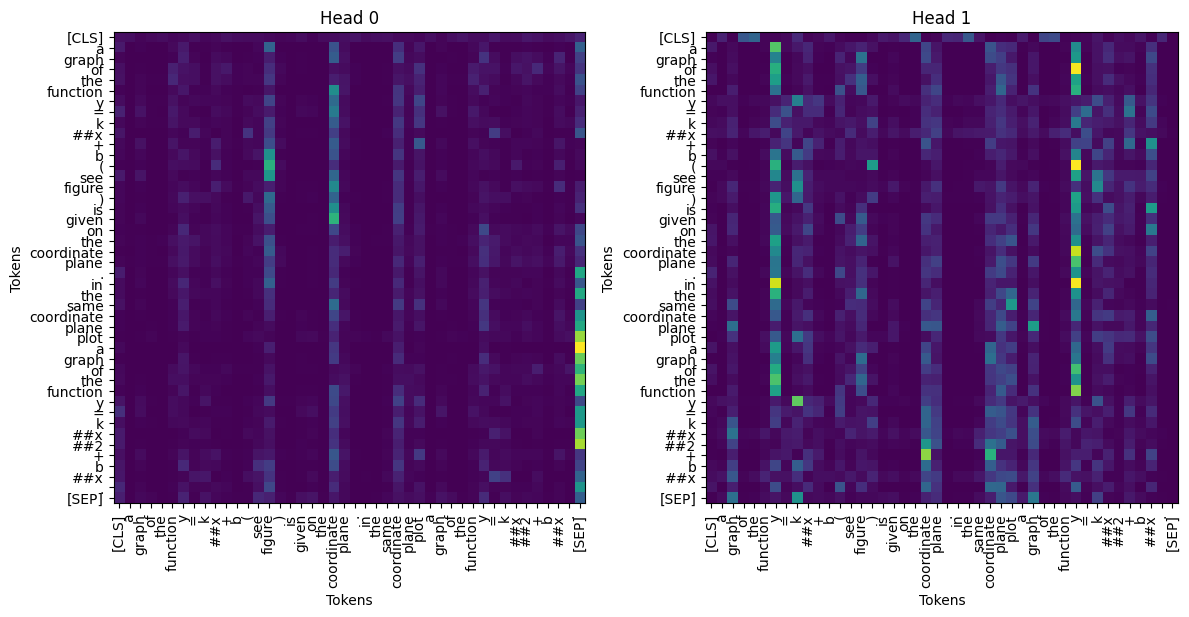

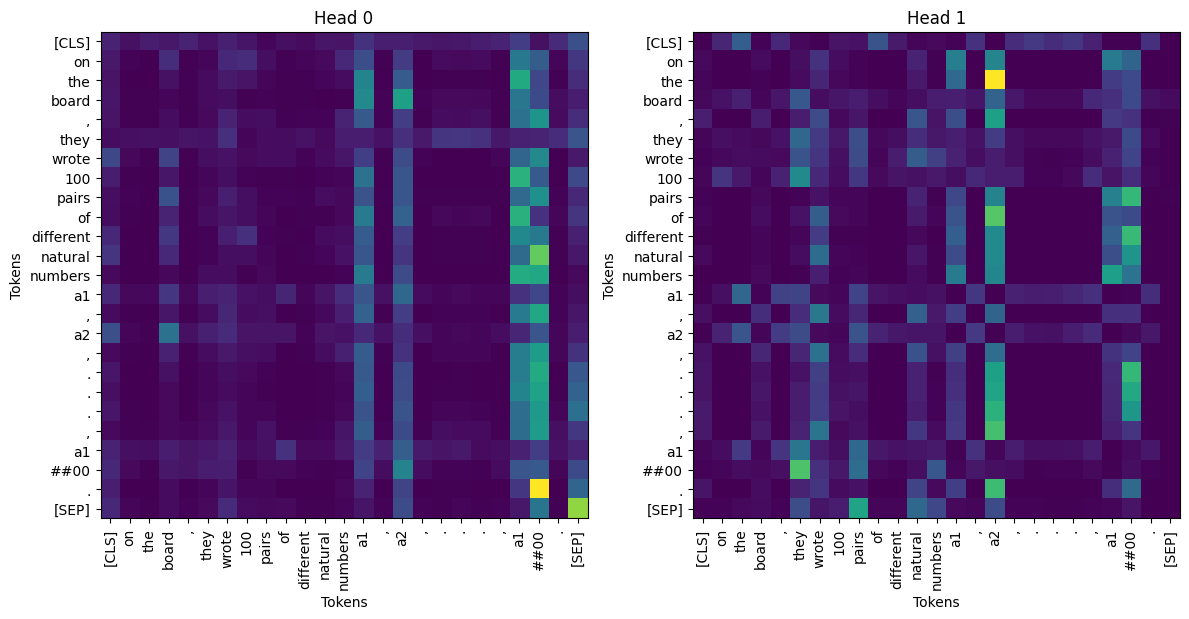

In [70]:
for sample in eng_text:
    draw_first_layer_attention_maps([0,1], sample, bert_tiny_transformer_model_freeze, ru=False)

Тут картина сильно лучше. После дообучение rubert очень хорошо видим связь слов в предложениях

Чего не скажешь про mathbert. Стало явно лучше, но не сильно.

Rubert в этом плане показывает лучший результат